In [1]:
import sys
sys.path.append('/opt/code/face/dual_shot')
import numpy as np
import keras.layers as KL
from keras import Model
from dual_conf import current_config as conf
from net.dual_shot import test_net
from prepare_data.generator import gen_test,layer_strides,map_size,e_scale,ratio
import os
from prepare_data.model_target import apply_regress,init_anchors

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
weight_path = os.path.join(conf.output_dir, 'weights.h5')
print('loading trained model from:',weight_path)

Using TensorFlow backend.
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


using: resnet50 as the base model
loading trained model from: /opt/code/face/dual_shot/train_out/weights.h5


## load model 

In [2]:
net_in = KL.Input([640, 640, 3], name='image_array')
ss_cls, ss_regr = test_net(net_in)
model = Model(inputs=[net_in], outputs=[ss_cls, ss_regr])
model.summary()
model.load_weights(weight_path, by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_array (InputLayer)        (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 646, 646, 3)  0           image_array[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 320, 320, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 320, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## load data

In [3]:
gen = gen_test(conf.batch_size, 'train')
x_val,y_val = next(gen)
print(x_val.shape,y_val)

Error bbox number to filter : 48,  bbox number: 159376
(4, 640, 640, 3) [array([[ 99.47214076, 174.42755826, 351.90615836, 426.66666667]])
 array([[216.04060914,   0.        , 300.50761421, 158.67768595]])
 array([[  0.        , 412.32104121,  60.61500615, 511.5835141 ],
       [ 96.03936039, 385.2494577 , 157.44157442, 479.65292842],
       [ 30.70110701, 298.48156182,  62.18942189, 336.65943601],
       [289.69249692, 340.13015184, 371.56211562, 419.95661605],
       [233.80073801, 327.63557484, 287.33087331, 397.74403471],
       [481.77121771, 302.64642082, 566.7896679 , 394.96746204],
       [589.61869619, 290.84598698, 640.        , 352.62472885],
       [407.77367774, 300.56399132, 470.7503075 , 370.67245119]])
 array([[316.96887686, 262.37188873, 371.52909337, 330.77598829]])]


## make prediction

In [4]:
ss_cls,ss_regr= model.predict(x_val)
print(ss_cls.shape,ss_regr.shape)

(4, 34125, 2) (4, 34125, 4)


In [5]:
ss_cls = np.exp(ss_cls) / np.sum(np.exp(ss_cls), axis=0)
ss_cls.shape

(4, 34125, 2)

In [6]:
# ss_cls = np.random.rand(4,conf.num_anchor,2)
# ss_regr = np.random.rand(4,conf.num_anchor,4)
# print(ss_cls.shape,ss_regr.shape)

## init anchors

In [7]:
e_anchors = init_anchors(layer_strides, map_size, ratio, e_scale)
e_anchors.shape

(34125, 4)

## apply delta 

In [8]:
pred_box = np.empty_like(ss_regr)
for i in range(len(ss_regr)):
    pred_box[i] = apply_regress(ss_regr[i],e_anchors)

## top 5k

In [9]:
pred_score = ss_cls[...,1]

In [10]:
sort_inds = np.argsort(-pred_score)

In [11]:
pred_score = pred_score[np.arange(pred_score.shape[0])[:,None], sort_inds]
pred_box = pred_box[np.arange(pred_box.shape[0])[:,None], sort_inds]

In [12]:
pred_score =pred_score[:,:5000]
pred_box =pred_box[:,:5000]
print(pred_score.shape,pred_box.shape)

(4, 5000) (4, 5000, 4)


In [13]:
pred_score

array([[0.99870986, 0.99533325, 0.9941625 , ..., 0.31207615, 0.31198725,
        0.31191748],
       [0.99941176, 0.9990464 , 0.9980286 , ..., 0.44756338, 0.44754794,
        0.44752508],
       [0.99097264, 0.99033767, 0.9902471 , ..., 0.69112825, 0.6910826 ,
        0.6909944 ],
       [0.9966446 , 0.9941588 , 0.99392575, ..., 0.6639817 , 0.66383374,
        0.66381794]], dtype=float32)

## nms

In [14]:

def bbox_vote(det):
    order = det[:, 4].ravel().argsort()[::-1]
    det = det[order, :]
    while det.shape[0] > 0:
        # IOU
        area = (det[:, 2] - det[:, 0] + 1) * (det[:, 3] - det[:, 1] + 1)
        xx1 = np.maximum(det[0, 0], det[:, 0])
        yy1 = np.maximum(det[0, 1], det[:, 1])
        xx2 = np.minimum(det[0, 2], det[:, 2])
        yy2 = np.minimum(det[0, 3], det[:, 3])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        o = inter / (area[0] + area[:] - inter)
        # get needed merge det and delete these det
        merge_index = np.where(o >= 0.3)[0]
        det_accu = det[merge_index, :]
        det = np.delete(det, merge_index, 0)
        if merge_index.shape[0] <= 1:
            continue
        det_accu[:, 0:4] = det_accu[:, 0:4] * np.tile(det_accu[:, -1:], (1, 4))
        max_score = np.max(det_accu[:, 4])
        det_accu_sum = np.zeros((1, 5))
        det_accu_sum[:, 0:4] = np.sum(det_accu[:, 0:4], axis=0) / np.sum(det_accu[:, -1:])
        det_accu_sum[:, 4] = max_score
        try:
            dets = np.row_stack((dets, det_accu_sum))
        except:
            dets = det_accu_sum
    dets = dets[dets[:, -1] > 0.5]  # ignore boxes with scores lower than 0.5
    dets = dets[0:750, :]
    return dets

In [15]:
#for i in range(len(pred_score)):
for i in range(1):
    det = np.concatenate([pred_box[i],np.expand_dims(pred_score[i],1)],axis=1)
    final_box = bbox_vote(det)

In [16]:
final_box.shape

(465, 5)

## visualize

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_anchor(img_array, anchor_list):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_array.astype(int))
    for a in anchor_list:
        y1,x1,y2,x2 = [int(i) for i in a]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


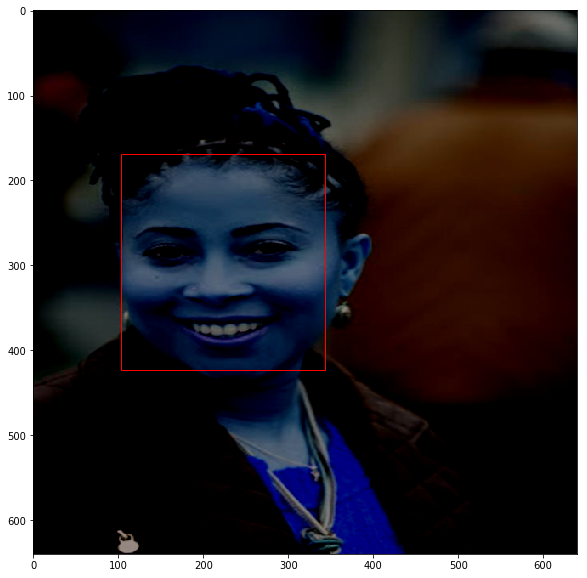

In [18]:
img_array = x_val[0]
anchor_list = final_box[:20,:4]
plot_anchor(img_array, anchor_list)